# Information Retrieval and Web Analytics

# Indexing + Modeling (TF-IDF)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Welcome to the first hands-on session of Information Retrieval and Web Analytics!

In this exercise you will implement a simple search engine to query a sample of Wikipedia articles. You will be provided with a sample of 500 Wikipedia articles in text format (some preprocessing has already been done to remove html tags).

For each article you have the following features:

- article id
- article title
- article body

This session is composed by three main parts:

1. **Create the index by going through the documents**
2. **Query the index to obtain a set of documents**
3. **Add some ranking to obtain a sorted set of documents when querying the index**



## 1. Create the index
The index is implemented through an **Inverted Index** which is the main data structure of our search engine. It maps the terms of our corpus (the collection of documents) to the documents that those terms appear in.

You will implement the index through a Python dictionary, and then you will use it to return the list of documents relevant for a query.

Each **vocabulary term** is a key in the index whose value is the list of documents that the term appears in.

    
*Figure 1* shows a basic implementation of an inverted index. However, there exists a special type of queries, named **Phrase Queries**, where the position of the terms in the document matters. Phrase Queries are those queries typed inside double quotes when we want the matching documents to contain the terms in the query exactly in the specified order.
    
In order to work with Phrase Queries we need to add some information in the inverted index. The new inverted index will store, for each term, the list of documents containing the term and the positions of the term in the corresponding document.

See *Figure 2*:
    
In the above example the term *Information* appears in document 1 at positions 0 (we start counting positions from 0), and in document 3 at position 0.
    
Notice that when implementing the index, you will need to perform some preprocessing:
    
    - Transform all words to lower case ( we don’t want to index *Information*, *information*, and *INFORMATION* differently.)
    - Remove stop words ( very common words like articles, etc.)
    - Apply Stemming (remove common endings from words. For example the stemmed version of the words fish, fishes, fishing, fisher, fished is the word 'fish')
    
But do not worry about that, we will provide you with simple tools to do it!

### Index implementation
To create the index you will perform the following steps:
- Loop over all documents of the collection provided in the dataset found in the project file `inputs/documents-corpus.tsv`.
- Concatenate the title and the text of the page.
- Lowercase all words.
- Get tokens (transform the string title+body into a list of terms)
- Remove stop words
- Stem each token
- Build the index following the model of Figure 2.

#### Load Python packages
Let's first import all the packages that you will need during this assignment.

In [2]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
from IPython.display import display
import json

#### Load data into memory
The dataset is stored in the TSV file, and it contains 500 Wikipedia articles (one article per line). For each article we have the document id, document title and document body separated by "|" character.

In [5]:
#docs_path = '/content/drive/MyDrive/Information_Retrieval_and_Web_Analytics/Project/IRWA_data_2023/Rus_Ukr_war_data.json'

#maping_doc = '/content/drive/MyDrive/Information_Retrieval_and_Web_Analytics/Project/IRWA_data_2023/Rus_Ukr_war_data_ids.csv'

docs_path = '/content/drive/MyDrive/1st TERM/IRWA/P1/Rus_Ukr_war_data.json'

maping_doc = '/content/drive/MyDrive/1st TERM/IRWA/P1/Rus_Ukr_war_data_ids.csv'

tweets = []
with open(docs_path, 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweets.append(tweet)

with open(maping_doc) as fp2:
    lines = fp2.readlines()
lines = [l.split() for l in lines]

mapping_dt = pd.DataFrame(lines, columns=['doc_id', 'id'])


In [6]:
print("Total number of tweets: {}".format(len(tweets)))

Total number of tweets: 4000


Implement the function ```build_terms(line)```.

It takes as input a text and performs the following operations:

- Transform all text to lowercase
- Tokenize the text to get a list of terms (use *split function*)
- Remove stop words
- Stem terms (example: to stem the term 'researcher', you will use ```stemmer.stem(researcher)```)

In [7]:
def build_terms(tweet):
    """
    Preprocess the tweet text removing stop words, stemming, tokenization, removing punctuation marks,
    and extracting relevant information like hashtags, date, likes, retweets, and URL.

    Argument:
    tweet -- dictionary representing a tweet

    Returns:
    processed_tweet -- a dictionary containing preprocessed tweet information
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    tweet_text = tweet.lower()
    tweet_text = tweet_text.replace(".", "")        #remove the . son war. counts as war
    tweet_text = tweet_text.split()  # Tokenize the tweet text
    tweet_text = [word for word in tweet_text if word not in stop_words]
    tweet_text = [stemmer.stem(word) for word in tweet_text]


    tweet_text = [word[1:] if word.startswith('#') else word for word in tweet_text]


    return tweet_text

In [8]:
tweets_stuctured = []
info_query = []

for tweet in tweets:
  tweet_id = tweet['id']
  created_at = tweet['created_at']

  tweet_text = build_terms(tweet['full_text'])

  hashtags = [word for word in tweet['full_text'].split() if word.startswith('#')]  # Extract hashtags without #



  likes = tweet['favorite_count']
  retweets = tweet['retweet_count']
  url = tweet['entities']['urls'][0]['expanded_url'] if tweet['entities']['urls'] else None

  # Return processed tweet information as a dictionary
  processed_tweet = {
      'created_at': created_at,
      'hashtags': hashtags,
      'likes': likes,
      'retweets': retweets,
      'url': url,
      'processed_text': tweet_text,
      'original_text': tweet['full_text'],
      'id': tweet_id,
  }
  info_query.append([processed_tweet['original_text'], processed_tweet['created_at'], processed_tweet['hashtags'], processed_tweet['likes'], processed_tweet['retweets'], processed_tweet['url'], processed_tweet['id']])
  tweets_stuctured.append([processed_tweet['original_text'], processed_tweet['created_at'], processed_tweet['hashtags'], processed_tweet['likes'], processed_tweet['retweets'], processed_tweet['url'], processed_tweet['id'], processed_tweet['processed_text']])


df_query = pd.DataFrame(info_query, columns=['Text', 'Created_time', 'Hashtags', 'Likes', 'Retweets', 'url', 'id'])

df2_structured = pd.DataFrame(tweets_stuctured, columns=['Text', 'Created_time', 'Hashtags', 'Likes', 'Retweets', 'url', 'id', 'processed_tweet'])

#now we map the id of the tweets with the id of the documents:

mapped_df = pd.concat([df2_structured, mapping_dt], axis=1, join="outer")

display(mapped_df)

,Text,Created_time,Hashtags,Likes,Retweets,url,id,processed_tweet,doc_id,id
0,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,Fri Sep 30 18:39:17 +0000 2022,"[#RussiainvadesUkraine, #UkraineRussiaWar]",0,0,None,1575918221013979136,"[@melsimmonsfcdo, wrong, dictat, putin', fasci...",doc_1,1575918221013979136
1,🇺🇦❤️ The Armed Forces liberated the village of...,Fri Sep 30 18:38:44 +0000 2022,"[#Drobysheve, #Lymansk, #Donetsk, #UkraineWar,...",0,0,None,1575918081461080065,"[🇺🇦❤️, arm, forc, liber, villag, drobyshev, ly...",doc_2,1575918081461080065
2,ALERT 🚨Poland preps anti-radiation tablets ove...,Fri Sep 30 18:38:23 +0000 2022,"[#NATO, #Putin, #Russia, #RussiaInvadedUkraine...",0,0,None,1575917992390823936,"[alert, 🚨poland, prep, anti-radi, tablet, nucl...",doc_3,1575917992390823936
3,I’m still waiting for my google map 🗺️ to upda...,Fri Sep 30 18:38:03 +0000 2022,"[#Putin, #UkraineRussiaWar]",0,0,None,1575917907774967809,"[i’m, still, wait, googl, map, 🗺️, updat, russ...",doc_4,1575917907774967809
4,@EmmanuelMacron probably you're right or you h...,Fri Sep 30 18:37:56 +0000 2022,"[#European, #UkraineRussiaWar]",0,0,None,1575917878410301441,"[@emmanuelmacron, probabl, right, say, it,, an...",doc_5,1575917878410301441
...,...,...,...,...,...,...,...,...,...,...
3995,🎥 Ukraine’s president has warned that Russia’s...,Wed Sep 28 16:05:00 +0000 2022,[#UkraineRussiaWar],4,1,None,1575154617620504576,"[🎥, ukraine’, presid, warn, russia’, “sham, re...",doc_3996,1575154617620504576
3996,Germany amusingly shares days old intelligense...,Wed Sep 28 16:04:19 +0000 2022,"[#germany, #UkraineRussiaWar]",0,0,https://www.tagesschau.de/investigativ/kontras...,1575154444165156864,"[germani, amusingli, share, day, old, intellig...",doc_3997,1575154444165156864
3997,The US Embassy in Moscow is urging Americans t...,Wed Sep 28 16:04:18 +0000 2022,"[#fakenewsfilter, #RealNews, #news, #RussianMo...",0,0,https://oigetit.app.link/GyxcQNf7Gtb,1575154440012812288,"[us, embassi, moscow, urg, american, leav, rus...",doc_3998,1575154440012812288
3998,After the staged fake referendum as of Septemb...,Wed Sep 28 16:03:56 +0000 2022,[#UkraineRussiaWar],13,2,None,1575154351273873410,"[stage, fake, referendum, septemb, 2022,, russ...",doc_3999,1575154351273873410


In [9]:
def create_index(tweets, mapping_dt):
    """
    Implement the inverted index

    Argument:
    lines -- collection of Wikipedia articles

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)
    tweet_index = {}
    for i, tweet in enumerate(tweets):  #
        #processed_tweet = build_terms(tweets[i])
        tweet_id = int(tweet[6])
        doc_id = mapping_dt[mapping_dt['id'] == str(tweet_id)]
        doc_id = (doc_id.values[0])[0]
        tweet_index[doc_id] = [tweet[0], tweet[1], tweet[2], tweet[3], tweet[4], tweet[5], tweet[6]]
        terms = tweet[7]


        current_page_index = {}

        for position, term in enumerate(terms): #
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list

        ## START CODE
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [doc_id, array('I', [position])]#'I' indicates unsigned int (int in Python)

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        ## END CODE

    return index, tweet_index

In [10]:
import time
start_time = time.time()
index, title_index = create_index(tweets_stuctured, mapping_dt)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 2.97 seconds


Notice that if you look in the index for ```researcher```you will not find any result, while if you look for ```research``` you will get some results. That happens because we are storing in the index stemmed terms.

In [11]:
print("Index results for the term 'fear': {}\n".format(index['war']))
print("First 10 Index results for the term 'fear': \n{}".format(index['war'][:10]))

Index results for the term 'fear': [['doc_12', array('I', [4, 8])], ['doc_15', array('I', [8])], ['doc_22', array('I', [14])], ['doc_25', array('I', [3])], ['doc_31', array('I', [15])], ['doc_44', array('I', [18])], ['doc_55', array('I', [16])], ['doc_67', array('I', [17])], ['doc_71', array('I', [6])], ['doc_77', array('I', [22])], ['doc_85', array('I', [18])], ['doc_87', array('I', [17])], ['doc_88', array('I', [8])], ['doc_99', array('I', [8])], ['doc_102', array('I', [3])], ['doc_129', array('I', [2])], ['doc_133', array('I', [1])], ['doc_137', array('I', [0])], ['doc_139', array('I', [2])], ['doc_153', array('I', [15])], ['doc_158', array('I', [12])], ['doc_165', array('I', [14])], ['doc_189', array('I', [1])], ['doc_194', array('I', [3])], ['doc_198', array('I', [15, 22])], ['doc_204', array('I', [3, 7])], ['doc_222', array('I', [7, 19])], ['doc_226', array('I', [11])], ['doc_236', array('I', [3])], ['doc_238', array('I', [5])], ['doc_240', array('I', [4])], ['doc_247', array('I'

## 2. Querying the Index

Even if before we mentioned that in case of phrase queries we need to take into account the position of the terms in the document and we have implemented an index that would allow us to also work with this type of queries, here you are going to implement a search function that will query the index without take into account the terms' positions.


We will use english Free Text Queries, that means that the query we will query the index using  a sequence of english words as query, and the output will be the list of documents that contain any of the query terms.

For instance if we write the query **"computer science"** the output will be the union of all documents containing the term "computer" with all documents containing the term "science".

In [12]:
def search(query, index):
    """
    The output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """

    query = build_terms(query)


    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs = [posting[0] for posting in index[term]]

            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass

    return docs

In [13]:
print("Insert your query (i.e.: Computer Science):\n")
query = 'Russia'
docs = search(query, index)
top = 10

list_tweets = []


for i, doc in enumerate(docs):
  list_tweets.append([doc, title_index[doc][0], title_index[doc][1], title_index[doc][2], title_index[doc][3], title_index[doc][4], title_index[doc][5], title_index[doc][6]])

df_search = pd.DataFrame(list_tweets, columns=['doc_id','Text', 'Created_time', 'Hashtags', 'Likes', 'Retweets', 'url', 'id'])

display(df_search)

Insert your query (i.e.: Computer Science):



,doc_id,Text,Created_time,Hashtags,Likes,Retweets,url,id
0,doc_2411,"""#Russia #Ukraine #RussianArmy\nEx-CIA directo...",Thu Sep 29 13:47:18 +0000 2022,"[#Ukraine, #RussianArmy, #NATO, #Putin, #Ukrai...",0,0,https://curiosityguide.org/trending/ex-cia-dir...,1575482351387578369
1,doc_3559,"""NATO: How Finland will fight in a war with Ru...",Wed Sep 28 19:22:50 +0000 2022,"[#Finland, #NATO, #Russia, #Ukraine, #Putin, #...",0,0,https://curiosityguide.org/trending/nato-finla...,1575204403170377729
2,doc_3043,Over coming days you'll see more &amp; more ne...,Thu Sep 29 04:05:14 +0000 2022,"[#Russia, #Putin, #Nordstream1, #Dreamspace, #...",0,0,None,1575335871254974464
3,doc_1148,#UkraineRussiaWar #Ukraine #Russia\n\n#Peskov'...,Fri Sep 30 10:04:53 +0000 2022,"[#UkraineRussiaWar, #Ukraine, #Russia, #Peskov...",0,0,None,1575788766844706816
4,doc_2737,#UkraineRussiaWar #Ukraine #Russia\n\n🤮 The Ge...,Thu Sep 29 09:52:16 +0000 2022,"[#UkraineRussiaWar, #Ukraine, #Russia, #Crimea...",0,0,https://www.pravda.com.ua/eng/news/2022/09/29/...,1575423202666450949
...,...,...,...,...,...,...,...,...
1469,doc_2955,There is more footage of WW1 than there is of ...,Thu Sep 29 05:38:21 +0000 2022,"[#UkraineRussiaWar, #ukraine, #Russia]",2,1,None,1575359304743489536
1470,doc_137,War in Ukraine: Some Russians anxious or angry...,Fri Sep 30 17:45:00 +0000 2022,"[#Ukraine, #UkraineWar, #UkraineRussiaWar, #Uk...",0,0,None,1575904558416642050
1471,doc_2075,"The council will make crucial and ""fundamental...",Thu Sep 29 19:52:37 +0000 2022,"[#UkraineUnderAttack, #UkraineRussiaWar, #Ukra...",0,0,None,1575574289209643010
1472,doc_1709,Rising conflict between Armenia and Azerbaijan...,Fri Sep 30 00:24:22 +0000 2022,"[#Armeniaazerbaijan, #UkraineRussiaWar]",25,13,None,1575642675826417664


## 3. Add Ranking with TF-IDF

When searching in a search engine, we are interested in obtain the results sorted by relevance or by some other criteria. Notice that **the above results are not ranked**.

Here you are going to implement the **TF-IDF (Term Frequency — Inverse Document Frequency)** mechanism and use it to obtain a list of ordered results.

TF-IDF is a weighting scheme that assigns each term in a document a weight based on its term frequency (FT) and the inverse document frequency (IDF).  The higher the scores, more important the term is.

##### TF
**TF** refers to the frequency of a term $t$ in a specific document $d$. The basic idea is that as a term appears more in the document it becomes more important. On the other side, if we only use pure term counts, longer documents will be favored more. Consider two documents with exactly the same content but one being twice longer by concatenating with itself.  The tf weights of each word in the longer document will be twice the shorter one, although they essentially have the same content. To deal with this issue we need to **normalize the term frequencies**.


$$tf_{t,d} = \dfrac{N_{t,d}}{||D||}\tag{1}$$


where ||D|| is the Euclidean norm.


Let $D=[t_1, t_2, \dots, t_n]$ be the document vector where $t_i$ represent the frequency of the term $i$, the  Euclidean Norm is calculated as


$$\sqrt{\sum_{t=1}^{n}t_i{^2}}\tag{2}$$


Note that $||D||$ is the same for all terms of a document.


##### IDF
A drawback of tf is that it considers all terms equally important. However, less common terms are more discriminative than others. To deal with this issue we introduce **idf (inverse document frequency)** that takes into account the number of documents containing the term.

$$idf_t = log\dfrac{N}{df_t}\tag{3}$$

where:

- $N$ is the total number of documents;
- $df_t$ is the number of documents containing the term $t$.

The log operation is applied to avoid that terms that appears in a high number of documents are considered to be too much less important, in this way we are smoothing (dampening) this difference.


In [14]:
def create_index_tfidf(tweets, num_documents, mapping_dt):
    """
    Implement the inverted index and compute tf, df and idf

    Argument:
    lines -- collection of Wikipedia articles
    num_documents -- total number of documents

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    tweet_index = defaultdict(str)
    idf = defaultdict(float)

    for i, tweet in enumerate(tweets):  #
        tweet_id = int(tweet[6])
        doc_id = mapping_dt[mapping_dt['id'] == str(tweet_id)]
        doc_id = (doc_id.values[0])[0]
        tweet_index[doc_id] = [tweet[0], tweet[1], tweet[2], tweet[3], tweet[4], tweet[5], tweet[6]]
        terms = tweet[7]

        current_page_index = {}

        for position, term in enumerate(terms):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [doc_id, array('I', [position])] #'I' indicates unsigned int (int in Python)

        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0

        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document.
            # posting ==> [current_doc, [list of positions]]
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] +=1  # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/len(df))), 4)

    return index, tf, df, idf, tweet_index


In [15]:
start_time = time.time()
num_documents = len(tweets)
index, tf, df, idf, title_index = create_index_tfidf(tweets_stuctured, num_documents, mapping_dt)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 354.53 seconds


In [16]:
def rank_documents(terms, docs, index, idf, tf, tweet_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query

        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]= (query_terms_count[term] / query_norm) * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....
            #tf[term][0] will contain the tf of the term "term" in the doc 26

            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot

    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    #print(doc_scores)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    result_docs=[tweet_index[x] for x in result_docs]

    doc_scores = [x[0] for x in doc_scores]        #here we save the doc_scores to do the Evaluation later


    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)

    #print ("".join(str(result_docs)), "\n")
    return result_docs, doc_scores

In [17]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)

    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs = [posting[0] for posting in index[term]]

            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass

    docs = list(docs)
    ranked_docs, doc_scores = rank_documents(query, docs, index, idf, tf, title_index)
    return ranked_docs, doc_scores

In [18]:
#evaluation_doc = '/content/drive/MyDrive/Information_Retrieval_and_Web_Analytics/Project/Evaluation_gt.csv'
evaluation_doc = '/content/drive/MyDrive/1st TERM/IRWA/P2/Evaluation_gt.csv'

df_evaluation = pd.read_csv(evaluation_doc)

df_evaluation = df_evaluation.apply(lambda x: x.astype(str).str.strip() if x.dtype == "O" else x)


In [19]:
query = "tank Kharkiv"
ranked_docs, doc_scores  = search_tf_idf(query, index)

df = pd.DataFrame(ranked_docs, columns=['Text', 'Created_time', 'Hashtags', 'Likes', 'Retweets', 'url', 'id'])
df['predicted_score'] = doc_scores
df['id'] = df['id'].astype(str)
df = df.merge(mapping_dt, on='id', how='left').drop(columns=['id'])
df_query1 = df[['predicted_score', 'doc_id']].copy()

df_evaluation_1 =  pd.DataFrame()
df_evaluation_1 = df_evaluation[df_evaluation['query_id'] == "Q1"]

df_evaluation_1Qs = df_evaluation[(df_evaluation['label'] == 1) & (df_evaluation['query_id'] != 'Q1')]
df_evaluation_1Qs['label'] = 0

merge_df1 = pd.concat([ df_evaluation_1Qs, df_evaluation_1], ignore_index = True)

merge_df1.rename(columns={'doc': 'doc_id'}, inplace=True)

merged_df1 = merge_df1.merge(df_query1,on='doc_id',how='left')
merged_df1['predicted_score'].fillna(0, inplace=True)

display(merged_df1)


<ipython-input-19-62dff9b3fd90>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_evaluation_1Qs['label'] = 0


,doc_id,query_id,label,predicted_score
0,doc_2052,Q3,0,0.000000
1,doc_164,Q3,0,0.000000
2,doc_411,Q3,0,0.000000
3,doc_1805,Q3,0,0.000000
4,doc_3442,Q3,0,0.000000
5,doc_2657,Q3,0,0.000000
6,doc_1534,Q3,0,0.000000
7,doc_383,Q3,0,0.000000
8,doc_1618,Q3,0,0.000000
9,doc_63,Q3,0,0.000000


In [20]:
query = "Nord Stream pipeline"
ranked_docs, doc_scores  = search_tf_idf(query, index)

df = pd.DataFrame(ranked_docs, columns=['Text', 'Created_time', 'Hashtags', 'Likes', 'Retweets', 'url', 'id'])
df['predicted_score'] = doc_scores
df['id'] = df['id'].astype(str)
df = df.merge(mapping_dt, on='id', how='left').drop(columns=['id'])
df_query2 = df[['predicted_score', 'doc_id']].copy()

df_evaluation_2 =  pd.DataFrame()
df_evaluation_2 = df_evaluation[df_evaluation['query_id'] == "Q2"]

df_evaluation_2Qs = df_evaluation[(df_evaluation['label'] == 1) & (df_evaluation['query_id'] != 'Q2')]
df_evaluation_2Qs['label'] = 0

merge_df2 = pd.concat([ df_evaluation_2Qs, df_evaluation_2], ignore_index = True)

merge_df2.rename(columns={'doc': 'doc_id'}, inplace=True)

merged_df2 = merge_df2.merge(df_query2,on='doc_id',how='left')
merged_df2['predicted_score'].fillna(0, inplace=True)


display(merged_df2)

<ipython-input-20-705002cfacd6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_evaluation_2Qs['label'] = 0


,doc_id,query_id,label,predicted_score
0,doc_2052,Q3,0,0.000000
1,doc_164,Q3,0,0.000000
2,doc_411,Q3,0,0.000000
3,doc_1805,Q3,0,0.000000
4,doc_3442,Q3,0,0.000000
5,doc_2657,Q3,0,0.000000
6,doc_1534,Q3,0,0.000000
7,doc_383,Q3,0,0.000000
8,doc_1618,Q3,0,0.000000
9,doc_63,Q3,0,0.000000


In [21]:
query = "annexation territories Russia"
ranked_docs, doc_scores  = search_tf_idf(query, index)

df = pd.DataFrame(ranked_docs, columns=['Text', 'Created_time', 'Hashtags', 'Likes', 'Retweets', 'url', 'id'])
df['predicted_score'] = doc_scores
df['id'] = df['id'].astype(str)
df = df.merge(mapping_dt, on='id', how='left').drop(columns=['id'])
df_query3 = df[['predicted_score', 'doc_id']].copy()

df_evaluation_3 =  pd.DataFrame()
df_evaluation_3 = df_evaluation[df_evaluation['query_id'] == "Q3"]

df_evaluation_3Qs = df_evaluation[(df_evaluation['label'] == 1) & (df_evaluation['query_id'] != 'Q3')]
df_evaluation_3Qs['label'] = 0

merge_df3 = pd.concat([ df_evaluation_3Qs, df_evaluation_3], ignore_index = True)

merge_df3.rename(columns={'doc': 'doc_id'}, inplace=True)

merged_df3 = merge_df3.merge(df_query3,on='doc_id',how='left')
merged_df3['predicted_score'].fillna(0, inplace=True)

display(merged_df3)

<ipython-input-21-0709590263d5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_evaluation_3Qs['label'] = 0


,doc_id,query_id,label,predicted_score
0,doc_1452,Q2,0,0.193776
1,doc_2908,Q2,0,0.000000
2,doc_618,Q2,0,0.284410
3,doc_2677,Q2,0,0.248628
4,doc_489,Q2,0,0.000000
5,doc_110,Q2,0,0.190393
6,doc_3439,Q2,0,0.000000
7,doc_3137,Q2,0,0.000000
8,doc_3913,Q2,0,0.000000
9,doc_2696,Q2,0,0.000000


In [22]:
#Choose query to study

current_query = "Q3"

if(current_query == "Q1"):
  current_query_res = merged_df1[merged_df1["query_id"] == current_query]

if(current_query == "Q2"):
  current_query_res = merged_df2[merged_df2["query_id"] == current_query]

if(current_query == "Q3"):
  current_query_res = merged_df3[merged_df3["query_id"] == current_query]


## Precision@K (P@K)

In [23]:
def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    relevant = sum(doc_score == 1)
    return float(relevant) / k

In [24]:
# Check for current query

k = 10
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["label"], current_query_res["predicted_score"], k)))
print("\nCheck on the dataset sorted by score:\n")
#current_query_res.sort_values("score", ascending=False).head(k)
current_query_res.sort_values("predicted_score", ascending=False).head(k)

==> Precision@10: 1.0


Check on the dataset sorted by score:



,doc_id,query_id,label,predicted_score
20,doc_2052,Q3,1,1.146254
25,doc_2657,Q3,1,0.935868
29,doc_63,Q3,1,0.837032
24,doc_3442,Q3,1,0.822165
26,doc_1534,Q3,1,0.768954
28,doc_1618,Q3,1,0.724970
23,doc_1805,Q3,1,0.705592
22,doc_411,Q3,1,0.568821
21,doc_164,Q3,1,0.548008
27,doc_383,Q3,1,0.529450


## Recall@K (R@K)

In [25]:
def recall_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    recall @k : float

    """
    relevant = sum(doc_score[:k] == 1)
    total_relevant = len(y_score[:k] > 0)

    return float(relevant) / total_relevant


In [26]:
k = 10
print("==> recall@{}: {}\n".format(k, recall_at_k(current_query_res["label"], current_query_res["predicted_score"], k)))
print("\nCheck on the dataset sorted by score:\n")
#current_query_res.sort_values("score", ascending=False).head(k)
current_query_res.sort_values("predicted_score", ascending=False).head(k)

==> recall@10: 1.0


Check on the dataset sorted by score:



,doc_id,query_id,label,predicted_score
20,doc_2052,Q3,1,1.146254
25,doc_2657,Q3,1,0.935868
29,doc_63,Q3,1,0.837032
24,doc_3442,Q3,1,0.822165
26,doc_1534,Q3,1,0.768954
28,doc_1618,Q3,1,0.724970
23,doc_1805,Q3,1,0.705592
22,doc_411,Q3,1,0.568821
21,doc_164,Q3,1,0.548008
27,doc_383,Q3,1,0.529450


## Average Precision@K (P@K)

In [27]:
def avg_precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1)
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1)
    return prec_at_i / gtp

In [28]:
avg_precision_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_score"]), 10)

1.0

In [29]:
current_query_res.sort_values("predicted_score", ascending=False).head(10)

,doc_id,query_id,label,predicted_score
20,doc_2052,Q3,1,1.146254
25,doc_2657,Q3,1,0.935868
29,doc_63,Q3,1,0.837032
24,doc_3442,Q3,1,0.822165
26,doc_1534,Q3,1,0.768954
28,doc_1618,Q3,1,0.724970
23,doc_1805,Q3,1,0.705592
22,doc_411,Q3,1,0.568821
21,doc_164,Q3,1,0.548008
27,doc_383,Q3,1,0.529450


## F1-Score@K

In [30]:
def f1_score_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    f1_score @k : float
    """
    precision = precision_at_k(doc_score, y_score, k)
    recall = recall_at_k(doc_score, y_score, k)
    f1_score = (2*precision*recall)/(precision+recall)

    return f1_score

In [31]:
# Check for query Q1
k = 10
print("==> F1-score@{}: {}\n".format(k, f1_score_at_k(current_query_res["label"], current_query_res["predicted_score"], k)))
print("\nCheck on the dataset sorted by score:\n")
#current_query_res.sort_values("score", ascending=False).head(k)
current_query_res.sort_values("predicted_score", ascending=False).head(k)

==> F1-score@10: 1.0


Check on the dataset sorted by score:



,doc_id,query_id,label,predicted_score
20,doc_2052,Q3,1,1.146254
25,doc_2657,Q3,1,0.935868
29,doc_63,Q3,1,0.837032
24,doc_3442,Q3,1,0.822165
26,doc_1534,Q3,1,0.768954
28,doc_1618,Q3,1,0.724970
23,doc_1805,Q3,1,0.705592
22,doc_411,Q3,1,0.568821
21,doc_164,Q3,1,0.548008
27,doc_383,Q3,1,0.529450


## Mean Average Precision (MAP)

In [32]:
def map_at_k(search_res, k=10):
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_score: relevance predicted through LightGBM.
        label: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["label"]),
                   np.array(curr_data["predicted_score"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

In [33]:
if(current_query == "Q1"):
  merged_df = merged_df1

if(current_query == "Q2"):
  merged_df = merged_df2

if(current_query == "Q3"):
  merged_df = merged_df3



map_k, avp = map_at_k(merged_df, 10)
map_k

0.3333333333333333

## Mean Reciprocal Rank (MRR)

In [34]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"

In [35]:
current_query_res.sort_values("predicted_score", ascending=False).head(10)

,doc_id,query_id,label,predicted_score
20,doc_2052,Q3,1,1.146254
25,doc_2657,Q3,1,0.935868
29,doc_63,Q3,1,0.837032
24,doc_3442,Q3,1,0.822165
26,doc_1534,Q3,1,0.768954
28,doc_1618,Q3,1,0.724970
23,doc_1805,Q3,1,0.705592
22,doc_411,Q3,1,0.568821
21,doc_164,Q3,1,0.548008
27,doc_383,Q3,1,0.529450


In [36]:
if(current_query == "Q1"):
  merged_df = merged_df1

if(current_query == "Q2"):
  merged_df = merged_df2

if(current_query == "Q3"):
  merged_df = merged_df3


labels = np.array(merged_df[merged_df['query_id'] == current_query]["label"])
scores = np.array(merged_df[merged_df['query_id'] == current_query]["predicted_score"])
np.round(rr_at_k(labels, scores, 10), 4)

1.0

In [37]:
mrr = {}
for k in [3, 5, 10]:
    RRs = []
    for q in merged_df['query_id'].unique():  # loop over all query ids
        labels = np.array(merged_df[merged_df['query_id'] == q]["label"])  # get labels for current query
        scores = np.array(merged_df[merged_df['query_id'] == q]["predicted_score"])  # get predicted score for current query
        RRs.append(rr_at_k(labels, scores, k))  # append RR for current query
    mrr[k] = np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k

In [38]:
mrr

{3: 0.3333, 5: 0.3333, 10: 0.3333}

## Normalized Discounted Cumulative Gain (NDCG)

In [39]:
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

In [40]:
k = 10
labels = np.array(merged_df[merged_df['query_id'] == current_query]["label"])
scores = np.array(merged_df[merged_df['query_id'] == current_query]["predicted_score"])
ndcg_k = np.round(ndcg_at_k(labels, scores, k), 4)
print("ndcg@{} for query with query_id={}: {}".format(k, current_query, ndcg_k))

ndcg@10 for query with query_id=Q3: 1.0


In [52]:
def get_tweet_vector(tweet, model):
    # Initialize an array to store word vectors
    word_vectors = []

    for word in tweet:
        # Check if the word is in the vocabulary of the Word2Vec model
        if word in model.wv:
            word_vector = model.wv[word]
            word_vectors.append(word_vector)

    # Calculate the mean of word vectors to represent the entire tweet
    if word_vectors:
        tweet_vector = np.mean(word_vectors, axis=0)
    else:
        # Handle the case when no words in the tweet are in the model's vocabulary
        tweet_vector = np.zeros(model.vector_size)

    return tweet_vector

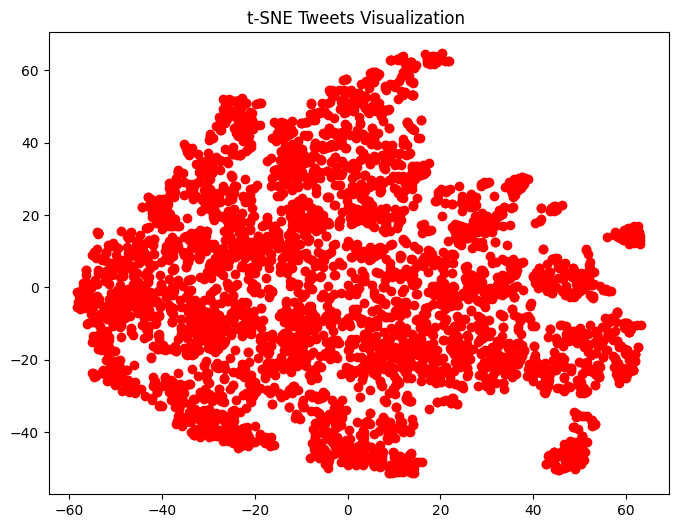

In [56]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tweet_list = mapped_df['Text'].tolist()
model_w2v = Word2Vec(sentences=tweet_list)

# Now, let's use the function to get vectors for all tweets
X = np.array([get_tweet_vector(tweet, w2v) for tweet in tweet_list])

# Initialize t-SNE with the desired number of components (usually 2 for 2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform your data to reduce its dimensionality to 2D
X_2D = tsne.fit_transform(X)

# Now, X_2D contains the 2D representation of your data.

# You can plot the data to visualize it:
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1],color = 'red')
plt.title("t-SNE Tweets Visualization ")
plt.show()

